In [1]:
import itertools 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

In [2]:
# get the data 
df = pd.read_csv(('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/'
'master/ESS_practice_data/ESSdata_Thinkful.csv')).dropna()

In [3]:
# define the target and features 
y = df['partner'] - 1 
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

In [4]:
# encode the categorical variable
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

In [5]:
#create the training and test sets 
offset = int(X.shape[0] * 0.8)

#put 80% of the data into the training set 
X_train, y_train = X[:offset], y[:offset]

# put 20% of the data into the test set 
X_test, y_test = X[offset:], y[offset:]

In [6]:
# now we have a classification problem to work on, 
# model has to use either deviance or exponential options for the loss function

# 500 iterations, with 2 deep trees and deviance loss function

params = {'n_estimators':500, 'max_depth':2, 'loss': 'deviance'}

In [7]:
# create and fit the model 

clf = ensemble.GradientBoostingClassifier(**params)    # thats awesome ... 

clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[843 158]
 [254 375]]


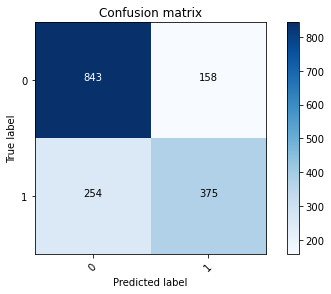

In [9]:
# create the data from the cm then plot it 

cm = confusion_matrix(y_test, predict_test)

plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix
[[0.84215784 0.15784216]
 [0.40381558 0.59618442]]


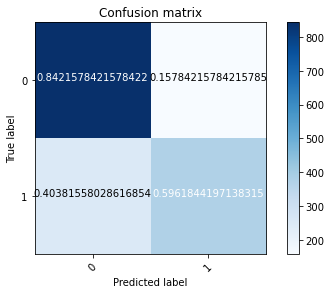

In [10]:
# now call the normalized version of this 
plot_confusion_matrix(cm, [0,1], True)

In [11]:
# get the accuracy of the model 
clf.score(X_test, y_test)

0.747239263803681

In [52]:
# get the precison 
y_pred = clf.predict(X_test)
precision_score(y_test, y_pred)

0.7786666666666666

In [53]:
# get the recall of the model 
recall_score(y_test, y_pred)

0.4642289348171701

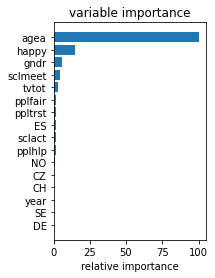

<Figure size 1440x1440 with 0 Axes>

In [24]:
# get the feature importance, show how important each one is 

feature_importance = clf.feature_importances_


#scale the importance and plot it 
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align= 'center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('relative importance')
plt.title('variable importance')
plt.figure(figsize=(20,20))
plt.show()



In [26]:
# lets improve the performance of the model 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8147 entries, 0 to 8593
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     8147 non-null   int64  
 1   tvtot    8147 non-null   float64
 2   ppltrst  8147 non-null   float64
 3   pplfair  8147 non-null   float64
 4   pplhlp   8147 non-null   float64
 5   happy    8147 non-null   float64
 6   sclmeet  8147 non-null   float64
 7   sclact   8147 non-null   float64
 8   gndr     8147 non-null   float64
 9   agea     8147 non-null   float64
 10  CH       8147 non-null   uint8  
 11  CZ       8147 non-null   uint8  
 12  DE       8147 non-null   uint8  
 13  ES       8147 non-null   uint8  
 14  NO       8147 non-null   uint8  
 15  SE       8147 non-null   uint8  
dtypes: float64(9), int64(1), uint8(6)
memory usage: 747.9 KB


In [32]:
# lets look for missing values 
X.isna().any()
#none 

year       False
tvtot      False
ppltrst    False
pplfair    False
pplhlp     False
happy      False
sclmeet    False
sclact     False
gndr       False
agea       False
CH         False
CZ         False
DE         False
ES         False
NO         False
SE         False
dtype: bool

In [42]:
# lets implement a grid search CV and see what accuracy we can get 

from sklearn.model_selection import GridSearchCV

param_grid = [{'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.50, 0.55, 0.60], 
               'max_depth' : [1, 2, 3, 4, 5], 
               'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8],
               'loss': ['deviance', 'exponential'],
               'min_samples_split': [2, 3, 4, 5, 6, 7, 8]}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2,
                                                  n_estimators=500),
             param_grid=[{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                            0.35, 0.45, 0.5, 0.55, 0.6],
                          'loss': ['deviance', 'exponential'],
                          'max_depth': [1, 2, 3, 4, 5],
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
grid_search.best_params_ 

{'learning_rate': 0.5,
 'loss': 'deviance',
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 6}

In [50]:
clf= ensemble.GradientBoostingClassifier(learning_rate = 0.5, loss = 'deviance', max_depth = 3, min_samples_split = 2, n_estimators = 6)

clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=6)

In [51]:
clf.score(X_train, y_train)

0.7581709375479515

In [ ]:
# slightly more accuracy than before. We could remove some variables to increase accuracy further 